In [1]:
import sys
from tensorflow.keras import backend as K
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.applications import InceptionResNetV2, VGG19
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Dropout, Concatenate, Dense, Average, Dot
from tensorflow.keras.layers import MaxPool2D, Conv2D, Add, ReLU, Lambda
from tensorflow.keras.layers import Input, Flatten, BatchNormalization


from tensorflow.keras.optimizers import Adam, RMSprop, Nadam
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, LearningRateScheduler
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
from Utilities import *

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import cv2

In [89]:
class ppixel:
    def __init__(self, pos_x, pos_y, value):
        self.pos_x = pos_x
        self.pos_y = pos_y
        self.inOrOut = None
        self.value = value
    
    def updateStat(self):
        p_ele = []
        values = []
        
        if self.pos_x > 0 and ppixels[self.pos_y][self.pos_x - 1].inOrOut == None:
            p_ele += [[self.pos_y, self.pos_x - 1]]
            values += [ppixels[self.pos_y][self.pos_x - 1].value]

        if self.pos_y > 0 and ppixels[self.pos_y - 1][self.pos_x].inOrOut == None:
            p_ele += [[self.pos_y - 1, self.pos_x]]
            values += [ppixels[self.pos_y - 1][self.pos_x].value]

        if self.pos_y < totalY - 1 and ppixels[self.pos_y + 1][self.pos_x].inOrOut == None:
            p_ele += [[self.pos_y + 1, self.pos_x]]
            values += [ppixels[self.pos_y + 1][self.pos_x].value]

        if self.pos_x < totalX - 1 and ppixels[self.pos_y][self.pos_x + 1].inOrOut == None:
            p_ele += [[self.pos_y, self.pos_x + 1]]
            values += [ppixels[self.pos_y][self.pos_x + 1].value]
        
        if whiteSpace - self.value >= 50:
            self.inOrOut = 'in'
            edge[self.pos_y][self.pos_x] = 125
            if len(values) != 0 and whiteSpace - max(values) < 50:
                return [p_ele[np.argmax(values)]]
            return []
        
        else:
            edge[self.pos_y][self.pos_x] = 255
            self.inOrOut = 'out'
            return p_ele

In [90]:
image = cv2.imread('./part_cell_further.PNG')
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
totalY, totalX = gray.shape
ppixels = [[ppixel(i, j, gray[j][i]) for i in range(totalX)] for j in range(totalY)]
whiteSpace = 255
edge = np.zeros(gray.shape)
toRun = [[0, 0]]
while len(toRun) != 0:
    running = toRun.pop()
    NewToRun = ppixels[running[0]][running[1]].updateStat()
    toRun += NewToRun

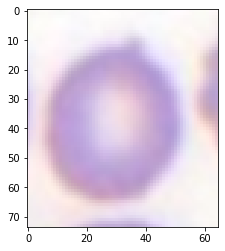

In [92]:
plt.imshow(image)

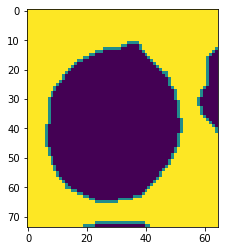

In [91]:
plt.imshow(edge)

In [ ]:
train_test_data = np.load('./images.npz')
images = train_test_data['arr_0']
labels = train_test_data['arr_1']
images = images[0:27000]
labels = labels[0:27000]
m = images.shape[0]
perm = np.random.permutation(m)

images = images[perm]
labels = labels[perm]
def build_LeNet(input_shape, output_shape):
    
    input_layer = Input(shape=input_shape, dtype='float64')
    
    conv_layer = Conv2D(16, kernel_size=3, padding='same', activation='relu')(input_layer)
    max_pool = MaxPool2D(pool_size=2, strides=2)(conv_layer)
    norm = BatchNormalization()(conv_layer)    
    dropout = Dropout(0.5)(norm)
    
    conv_layer = Conv2D(32, kernel_size=3, padding='same', activation='relu')(dropout)
    max_pool = MaxPool2D(pool_size=2, strides=2)(conv_layer)
    norm = BatchNormalization()(conv_layer)    
    dropout_res_base = Dropout(0.5)(norm)
    
    # residual block branch 1
    conv_layer_rb1 = Conv2D(32, kernel_size=3, padding='same', activation='relu')(dropout_res_base)
    norm_rb1 = BatchNormalization()(conv_layer_rb1)    
    dropout_rb1 = Dropout(0.5)(norm_rb1)
    
    conv_layer_rb1 = Conv2D(32, kernel_size=3, padding='same', activation='relu')(dropout_rb1)
    norm_rb1 = BatchNormalization()(conv_layer_rb1)    
    dropout_rb1 = Dropout(0.5)(norm_rb1)
    
    res_block_rb1 = Add()([dropout_res_base, dropout_rb1])
    res_activation_rb1 = ReLU()(res_block_rb1)
#     res_activation_rb1 = ReLU()(dropout_rb1)
    
    
    # residual block branch 2
    conv_layer_rb2 = Conv2D(32, kernel_size=3, padding='same', activation='relu')(dropout_res_base)
    norm_rb2 = BatchNormalization()(conv_layer_rb2)    
    dropout_rb2 = Dropout(0.5)(norm_rb2)
    
    conv_layer_rb2 = Conv2D(32, kernel_size=3, padding='same', activation='relu')(dropout_rb2)
    norm_rb2 = BatchNormalization()(conv_layer_rb2)    
    dropout_rb2 = Dropout(0.5)(norm_rb2)
    
    res_block_rb2 = Add()([dropout_res_base, dropout_rb2])
    res_activation_rb2 = ReLU()(res_block_rb2)
    # merge res branchses
    average = Average()([res_activation_rb1, norm, res_activation_rb2])
    norm = BatchNormalization()(average)
    flatten = Flatten()(res_activation_rb1)
    dense = Dense(120, activation='relu')(flatten)
    output = Dense(output_shape, activation='softmax')(dense)
    model = Model(inputs=[input_layer], outputs=[output])
    model.compile(loss='sparse_categorical_crossentropy',
              optimizer='Adam',  #(learning_rate=0.00005)',
               metrics=['accuracy'])
    
    
    return model

m, i, j, k = images.shape


model = build_LeNet(input_shape=(i, j, k), output_shape=2)

model.summary()
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2)
checkpointer = ModelCheckpoint(filepath="LetNet_weights_augmented.hdf5",
                              verbose=1,
                              save_best_only=True,
                              monitor='val_accuracy')

model_log = model.fit(x=X_train, y=y_train,
                      validation_split=0.2,
                      epochs=10,
                      batch_size=64,
                      shuffle=True,
                      callbacks=[checkpointer])
model = load_model('LetNet_weights_augmented.hdf5')

yh_test = model.predict(X_test)

yh_test_max = yh_test.argmax(axis=1)
print('accuracy: {}'.format((1-ErrorRate(y_test, yh_test_max)).round(5)))